In [126]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd

# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
from sequence_logo import *
mwc.set_plotting_style()

# Set font and color palette
path = '/Library/Fonts/Lucida Sans Unicode.ttf'
prop = matplotlib.font_manager.FontProperties(fname=path)
matplotlib.rcParams['font.family'] = prop.get_name()

colors_qual=sns.color_palette(
    ['#bf0087', '#e5b600', '#40ac00', '#5233ea', '#bf3800', '#00acac']) # Colors for non-sequential data
sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

rc = {'lines.linewidth': 2,
      'axes.labelsize': 12,
      'axes.titlesize': 12,
      'axes.facecolor': '#E3DCD0',
      'xtick.major' : 10,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'font.family': 'Arial',
      'grid.linestyle': ':',
      'grid.linewidth': 1.5,
      'grid.color': '#ffffff',
      'mathtext.fontset': 'stixsans',
      'mathtext.sf': 'sans',
      'legend.frameon': True,
      'legend.fontsize': 8}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)

In [127]:
# Define functions for plotting the values for sequence logos without actually plotting sequence logos
def info_array(probs):
    '''Returns an array of information content for each sequence position.'''
    info_list = []
    for row in probs:
        info_list.append(2 + sum(val * np.log2(val) for val in row))
    return info_list

def prob_array(matrix):
    '''Returns an array of probabilities associated with each base at each position.
    Should be a vertical matrix (i.e. 4 columns of length L, where L is the length of the
    binding site.)'''
    probs = []
    for row in matrix:
        probs.append([np.exp(-val) / sum(np.exp(-row)) for val in row])
    return probs

In [128]:
# Load matrices for all binding sites
xylR_left = []
xylR_left_pref = []
xylR_right = []
xylR_right_pref = []

for j in range(1, 4):
    # Load array
    array = np.loadtxt('../../data/models/splits/xylR_left_split%i' % j, skiprows=5, usecols=(1,2,3,4))
    
    # Fix each matrix so that the lowest energy sequence is fixed at 0
    minvals = []
    for n, row in enumerate(array):
        minval = min(row)
        for m, val in enumerate(row):
            array[n][m] = val - minval
    
    # Infer a hypothetical scaling factor
    array_vals = np.array([val for val in array.ravel() if val != 0])
    scaling_factor = 2.5/np.mean(array_vals)
    scaled_array = array * scaling_factor
    
    # Calculate probability and information
    probs = np.array(prob_array(scaled_array))
    info = np.array(info_array(probs))
    
    sequence_pref = []
    for z in range(len(info)):
        sequence_pref.append(info[z] * probs[z])
    
    xylR_left.append(scaled_array)
    xylR_left_pref.append(sequence_pref)
    
for k in range(1, 4):
    # Load array
    array = -np.loadtxt('../../data/models/splits/xylR_right_split%i' % k, skiprows=6, usecols=(1,2,3,4))
    
    # Fix each matrix so that the lowest energy sequence is fixed at 0
    minvals = []
    for a, row in enumerate(array):
        minval = min(row)
        for b, val in enumerate(row):
            array[a][b] = val - minval
    
    # Infer a hypothetical scaling factor
    array_vals = np.array([val for val in array.ravel() if val != 0])
    scaling_factor = 2.5/np.mean(array_vals)
    scaled_array = array * scaling_factor
    
    # Calculate probability and information
    probs = np.array(prob_array(scaled_array))
    info = np.array(info_array(probs))
    
    sequence_pref = []
    for x in range(len(info)):
        sequence_pref.append(info[x] * probs[x])
        
    xylR_right.append(scaled_array)
    xylR_right_pref.append(sequence_pref)

In [129]:
xylR_left_means = np.mean(xylR_left, axis=0)
xylR_left_err = np.std(xylR_left, axis=0)
xylR_left_pref_means = np.mean(xylR_left_pref, axis=0)
xylR_left_pref_err = np.std(xylR_left_pref, axis=0)
xylR_right_means = np.mean(xylR_right, axis=0)
xylR_right_err = np.std(xylR_right, axis=0)
xylR_right_pref_means = np.mean(xylR_right_pref, axis=0)
xylR_right_pref_err = np.std(xylR_right_pref, axis=0)


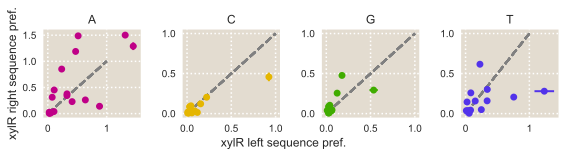

In [135]:
base_list = ['A', 'C', 'G', 'T']

fig, ax = plt.subplots(ncols=4, figsize=(8,2))

for i in range(len(xylR_left_means)):
    for j in range(len(base_list)):
        ax[j].plot([0, 1], [0, 1], ls='--', color='gray')
        ax[j].errorbar(xylR_left_pref_means[i][j], xylR_right_pref_means[i][j],\
                       xerr=xylR_left_pref_err[i][j], yerr=xylR_right_pref_err[i][j], marker='o', color=colors_qual[j])
        ax[j].set_title(base_list[j])

ax[0].set_ylabel('xylR right sequence pref.')
plt.figtext(0.5, 0, 'xylR left sequence pref.', ha='center')
        
plt.tight_layout()
plt.savefig('preference_scatter.pdf', bbox_inches='tight')

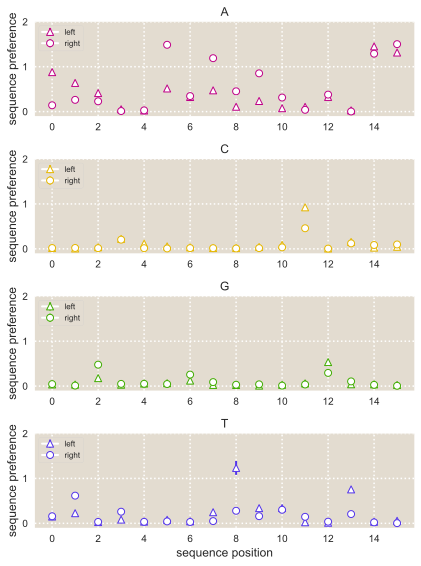

In [187]:
base_list = ['A', 'C', 'G', 'T']
xrange = np.arange(len(xylR_right_pref_means))
 
fig, ax = plt.subplots(nrows=4, figsize=(6, 8))


for j in range(len(base_list)):
    ax[j].errorbar(xrange[0], xylR_left_pref_means[0][j], yerr=xylR_left_pref_err[0][j],\
                   marker='^', color='white', markeredgewidth=1, ecolor=colors_qual[j], \
                   markeredgecolor=colors_qual[j], label='left')
    ax[j].errorbar(xrange[0], xylR_right_pref_means[0][j], yerr=xylR_right_pref_err[0][j],\
                   marker='o', color='white', markeredgewidth=1, ecolor=colors_qual[j], \
                   markeredgecolor=colors_qual[j], label='right')
    
    for i in range(1, len(xrange)):
        ax[j].errorbar(xrange[i], xylR_left_pref_means[i][j], yerr=xylR_left_pref_err[i][j],\
                       marker='^', color='white', markeredgewidth=1, ecolor=colors_qual[j], \
                       markeredgecolor=colors_qual[j])
        ax[j].errorbar(xrange[i], xylR_right_pref_means[i][j], yerr=xylR_right_pref_err[i][j],\
                       marker='o', color='white', markeredgewidth=1, ecolor=colors_qual[j], \
                       markeredgecolor=colors_qual[j])
        ax[j].set_title(base_list[j])
        ax[j].set_ylim(-0.1, 2)
        ax[j].set_ylabel('sequence preference')
        ax[j].legend(loc='upper left')

ax[3].set_xlabel('sequence position')

plt.tight_layout()
plt.savefig('preference_compare.pdf', bbox_inches='tight')